In [2]:
import torch
import os
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import sys
yolov5_path = "./yolov5"
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
from yolov5.utils.loss import ComputeLoss
from yolov5.models.yolo import Model
import yaml
import zipfile

In [3]:
#Load dataset{"username":"ankitht","key":"adde58a57a33baa717acaea4fe7fc203"}
os.environ["KAGGLE_KEY"] = "ankitht"
os.environ["KAGGLE_USERNAME"] = "dde58a57a33baa717acaea4fe7fc203"
import kaggle

dataset_name = "farzadnekouei/top-view-vehicle-detection-image-dataset"

kaggle.api.dataset_download_files(dataset_name,path=".")
with zipfile.ZipFile("top-view-vehicle-detection-image-dataset.zip") as zf:
        zf.extractall(".")

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/top-view-vehicle-detection-image-dataset


In [4]:
class VehicleDataset(Dataset):
    def __init__(self,image_dir,label_dir,transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        #Convert color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label_path = os.path.join(self.label_dir,self.label_files[idx])

        with open(label_path,"r") as f:
            label_data = f.readlines()

        boxes = []

        for line in label_data:
            split_line = line.strip().split()
            class_id = int(split_line[0])
            x_center, y_center, width, height = map(float, split_line[1:])
            boxes.append([class_id,x_center,y_center,width,height])
        boxes = torch.tensor(boxes,dtype=torch.float32)
        return image, boxes

def display_sample(image, boxes):
    #Displays sample image from dataset
    image = image.permute(1,2,0).numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    h,w, c = image.shape

    for box in boxes:
        class_id, x_center, y_center, width, height = box

        x_center *= w
        y_center *= h
        width *= w
        height *= h
        #Top left corner
        x = x_center - width / 2
        y = y_center - height / 2
        rectangle = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor="g",facecolor="none")
        ax.add_patch(rectangle)
    plt.show()

def collate(batch):
    images = torch.stack([item[0] for item in batch],dim=0)
    targets = [item[1] for item in batch]
    return images, targets

train_images = "Vehicle_Detection_Image_Dataset/train/images"

train_labels = "Vehicle_Detection_Image_Dataset/train/labels"

valid_images = "Vehicle_Detection_Image_Dataset/valid/images"

valid_labels = "Vehicle_Detection_Image_Dataset/valid/labels"
        

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640,640)),
    transforms.ToTensor()

])

train_dataset = VehicleDataset(train_images,train_labels,transform)
train_dataloader = DataLoader(train_dataset,batch_size=5,shuffle=True,collate_fn=collate)

valid_dataset = VehicleDataset(valid_images,valid_labels,transform)
valid_dataloader = DataLoader(valid_dataset,batch_size=5,collate_fn=collate)


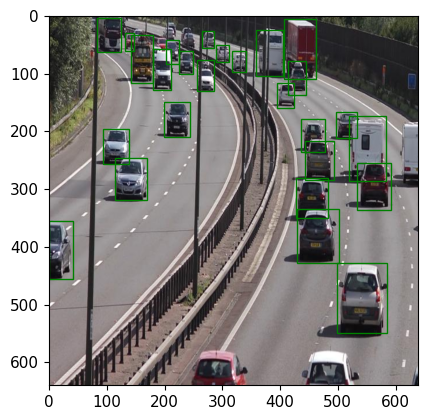

In [5]:
#Example image
display_sample(train_dataset[5][0],train_dataset[5][1])

In [6]:


#model = torch.hub.load("ultralytics/yolov5",'yolov5s',pretrained=True)
model = Model("modified_yolov5s.yaml",ch=3,nc=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)




                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1   1182720  

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [20]:
#Any box with a confidence below conf_thresh is assumed to not be detected, and box with more than a iou_thresh overlap are combined.
def process_predictions(preds, conf_thresh = .2, iou_thresh = .45):
    formatted_predictions = []
    for pred in preds:
        boxes = pred[:,:4]
        scores = pred[:,4]
        labels = pred[:,5].int()
        
        mask = scores >= conf_thresh 
        boxes, scores, labels = boxes[mask], scores[mask], labels[mask]
        
        #Need to get nms working properly.

        #Make sure to get nms working, need to remove overlapping boxes
        # mask = nms(boxes,scores,iou_thresh)
        # boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

        formatted_predictions.append({"boxes":boxes,"scores":scores,"labels":labels})

    return formatted_predictions
    
def process_targets(targets):
    processed_targets = []
    for target in targets:
        boxes = target[:,1:]
        labels = target[:,1].int()
        processed_targets.append({"boxes":boxes,"labels":labels})
    return processed_targets

def visualize_single_prediction(image, prediction, target):
    """
    Visualize a single image with ground truth and predicted bounding boxes and labels.

    Args:
    - image (Tensor): The image tensor of shape (3, H, W).
    - prediction (dict): Dictionary containing 'boxes', 'scores', and 'labels' for predictions.
    - target (dict): Dictionary containing 'boxes' and 'labels' for ground truth.
    """
    # Convert image to HWC format for plotting
    image = image.permute(1, 2, 0).cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    gt_boxes = target['boxes'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image)

    # Plot ground truth boxes (green)
    h,w, c = image.shape
    
    for box,label in zip(gt_boxes,gt_labels):
        x_center, y_center, width, height = box

        x_center *= w
        y_center *= h
        width *= w
        height *= h
        
        #Top left corner
        x = x_center - width / 2
        y = y_center - height / 2
        #The bottom right corner appears to be right
        rectangle = patches.Rectangle((x,y),width,height,linewidth=2,edgecolor="g",facecolor="none")
        ax.add_patch(rectangle)
    # Plot predicted boxes (red)
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        x_min, y_min, width, height = box #Something wrong with max maybe
        x_center = x_min - width / 2
        y_center = y_min - height / 2
        rect = patches.Rectangle((x_center, y_center),width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min, f'Pred: {label} ({score:.2f})', color='r', fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

## Test model on a single image, just to make sure i'm properly visualizing boxes and stuff while training

In [21]:

num_epochs = 10
pre_trained = torch.load("yolov5s.pt",map_location=device)
state_dict  = pre_trained["model"].state_dict()

model_state_dict = model.state_dict()

pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}
model_state_dict.update(pretrained_dict)
model.load_state_dict(model_state_dict)

with open("yolov5/data/hyps/hyp.scratch-med.yaml") as f:
    hyp = yaml.safe_load(f)
model.hyp = hyp

Epoch [1/20], Training Loss: 0.4180821027882673


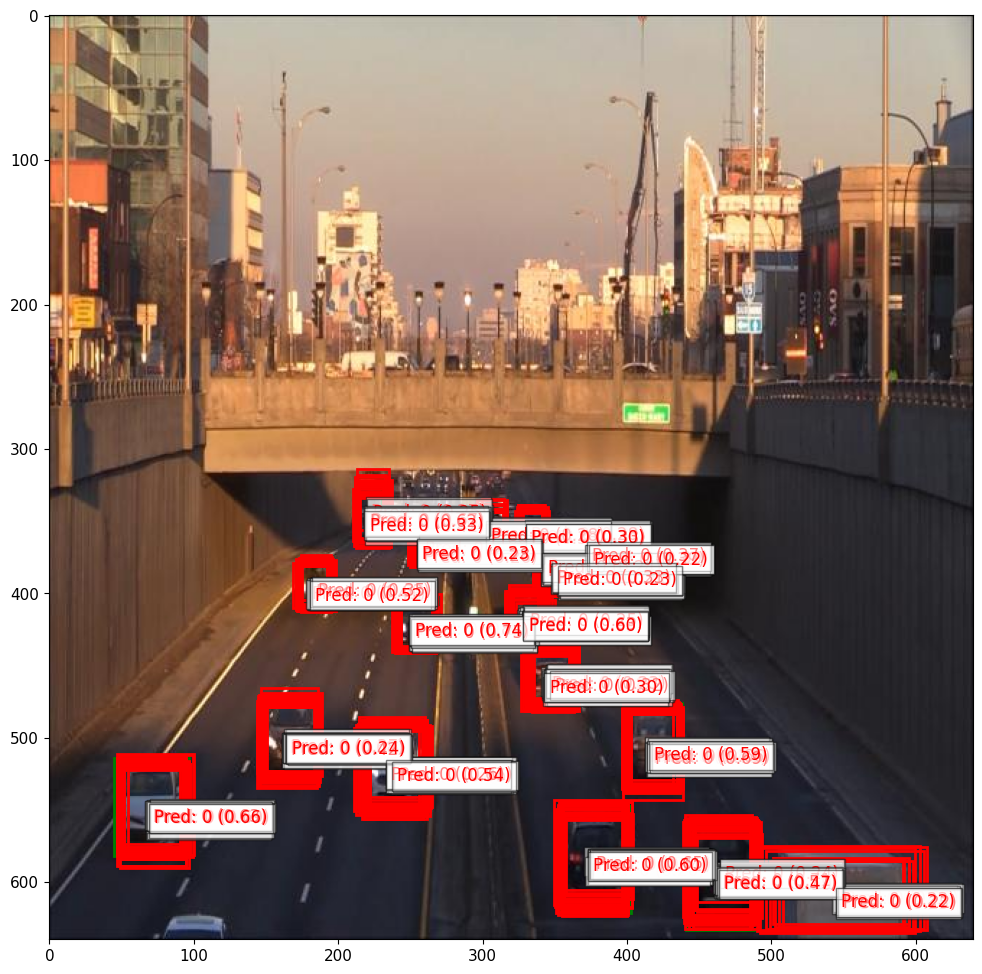

Epoch [1/20], mAP: 0.0
Epoch [2/20], Training Loss: 0.312696673458925


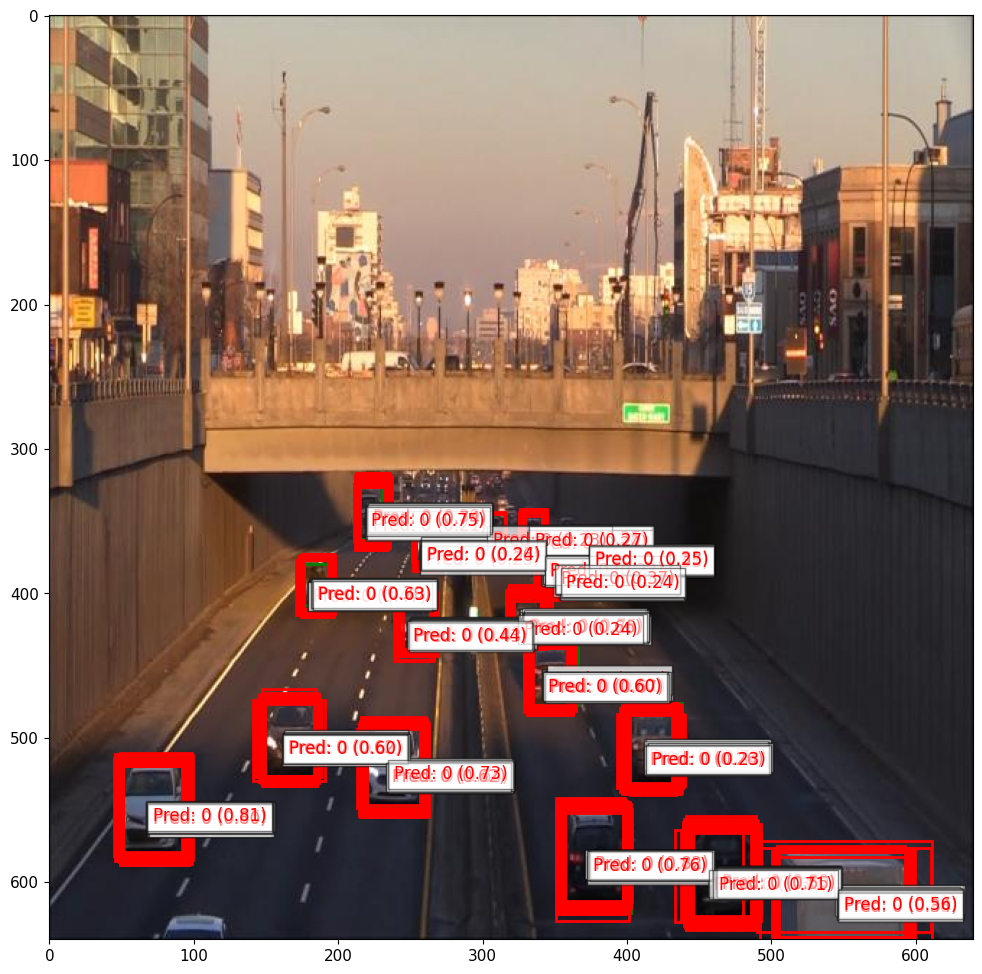

Epoch [2/20], mAP: 0.0


KeyboardInterrupt: 

In [22]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = ComputeLoss(model)
metric = MeanAveragePrecision()


# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        # Move data to the device
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        targets = []
        for i, label in enumerate(labels):
            label = label.to(device)
            img_ids = torch.full((label.size(0), 1), i, dtype=torch.float32, device=device)
            target = torch.cat((img_ids, label), dim=1)
            targets.append(target)
        targets = torch.cat(targets, dim=0)
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss, loss_items = loss_fn(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss}")

    # Validation loop
    model.eval()
    metric.reset()
    with torch.inference_mode():
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]
            targets = process_targets(labels)
            
            outputs = model(images)
            predicts  = process_predictions(outputs[0])
            
            metric.update(predicts, targets)
        visualize_single_prediction(images[4],predicts[4],targets[4])

    mAP = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], mAP: {mAP['map']}")

print("Training complete.")

#I really think i'm incorrectly drawing bounding boxes.
